# Gaussian Process - A Brief Overview

In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
from scipy import optimize

%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Gaussian distribution

One of the most studied distribution, with lots of nice (i.e., easy for computation) properties.  

$$p(x \mid \mu, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$  

where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix.

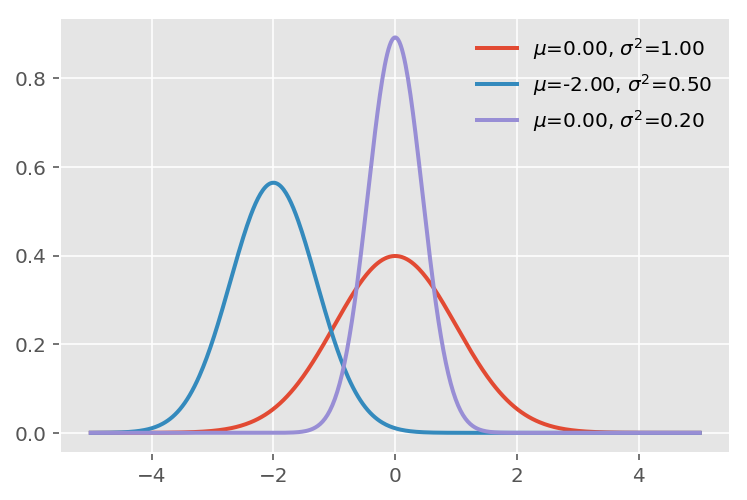

In [2]:
x = np.linspace(-5, 5, 500)
mu = [0, -2, 0]
sd = [1, .5, .2]
for mi, si in zip(mu, sd):
    rv = stats.norm(mi, np.sqrt(si))
    plot(x, rv.pdf(x), lw=2, label=('$\mu$=%.2f, $\sigma^2$=%.2f' %(mi,si)))
legend(loc='best', frameon=False);

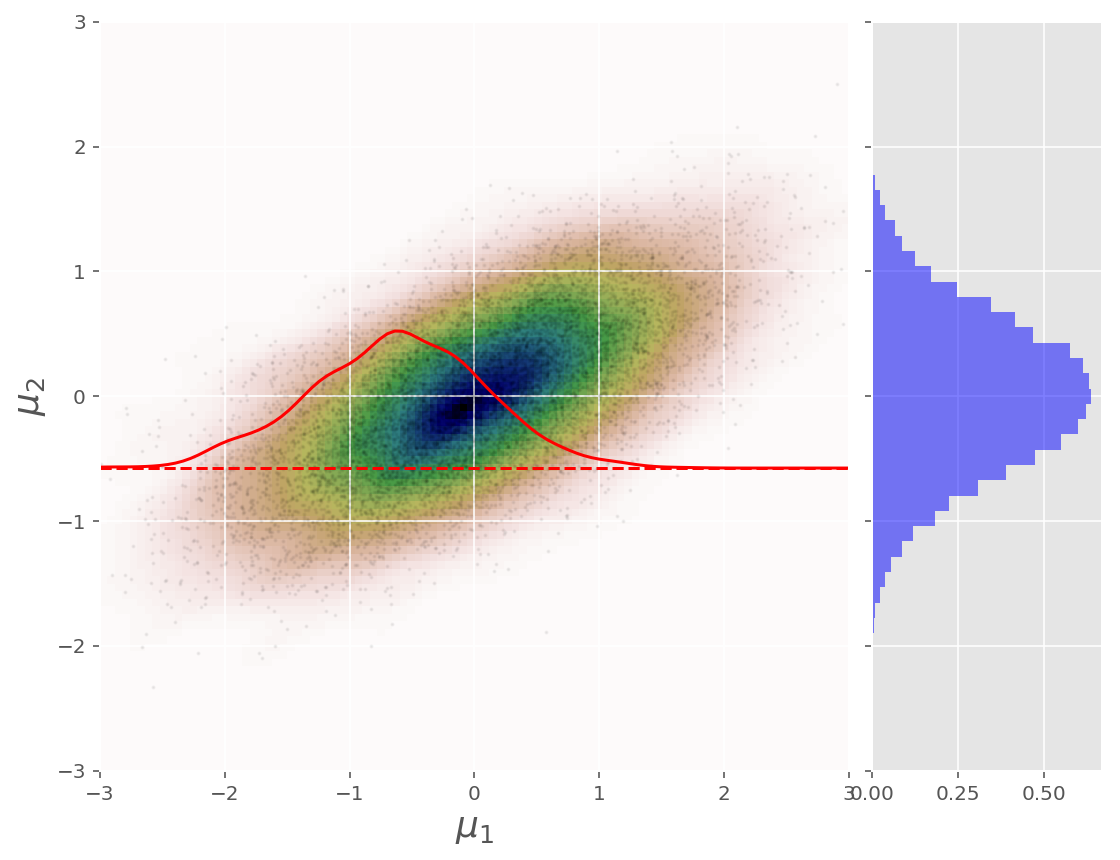

In [3]:
N = 10000
X1 = stats.norm.rvs(loc=0,scale=.5,size=(2,N))
K2 = np.asarray([[3.5,1.5],[1.5,1.5]])
L = np.linalg.cholesky(K2)
obs1 = np.transpose(np.dot(L,X1))
x, y = obs1[:,0], obs1[:,1]

from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()         # no labels

burnin=500 # set to zero to plot the one without burnin

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histy = [left_h, bottom, 0.2, height]

# now determine limits by hand:
binwidth1 = 0.25

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axScatter.set_xlim((-3, 3))
axScatter.set_ylim((-3, 3))

axHisty = plt.axes(rect_histy)

# no labels
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
X, Y = np.mgrid[-3:3:100j, -3:3:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
kernel = stats.gaussian_kde(obs1.T)
Z = np.reshape(kernel(positions), X.shape)
axScatter.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[-3, 3, -3, 3])
axScatter.plot(x, y, 'k.', markersize=2, alpha=.05)
axScatter.plot(Y[60], np.rot90(Z)[60]*5+X[100-60], 'r', markersize=2)
axScatter.plot(Y[60], X[100-60], '--r', markersize=2)

axScatter.set_xlabel(r'$\mu_1$',fontsize=18)
axScatter.set_ylabel(r'$\mu_2$',fontsize=18)

bins2 = np.linspace(-3, 3, 50)
axHisty.hist(y, bins=bins2, color='b', alpha=.5, normed=True, orientation='horizontal')
axHisty.set_ylim(axScatter.get_ylim())

plt.show()

A set of Gaussians are generally easy to work with. For example, sum of Gaussians is also Gaussian, and many distribution is actually generated by operation with Gaussian. Moreover, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$


# Gaussian distribution with infinite dimension  

The following text is largely adapted from Chris Fonnesbeck's [GP_showdown](https://github.com/fonnesbeck/gp_showdown)

Gaussian process is a generalization of a multivariate Gaussian distribution to infinitely many variables. Informally, you can think of a infinitely long vector as a function, cause a function just takes continuous values and return some outputs. A Gaussian process is thus defined as an infinite collection of random variables, which any finite subset have a Gaussian distribution.

Moreover, having an infinite-dimensional Gaussian is not a problem when it is treated as a function. We can evaluated the function at the points where we have information.

For this reason, Gaussian process is often defined as ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

Using the marginalization property makes working with Gaussian process easy: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, a 1D GP:

$$ p(f(x))\sim \mathcal{GP}(m(x)=0, k(x,x^{\prime}) = \exp\left(-\frac{1}{2}(x-x^{\prime})^2\right)) $$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points. Focus on a finite subset of function values, and plot the coordinates of $f(x)$ as a function of the corresponding $x$ values: 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


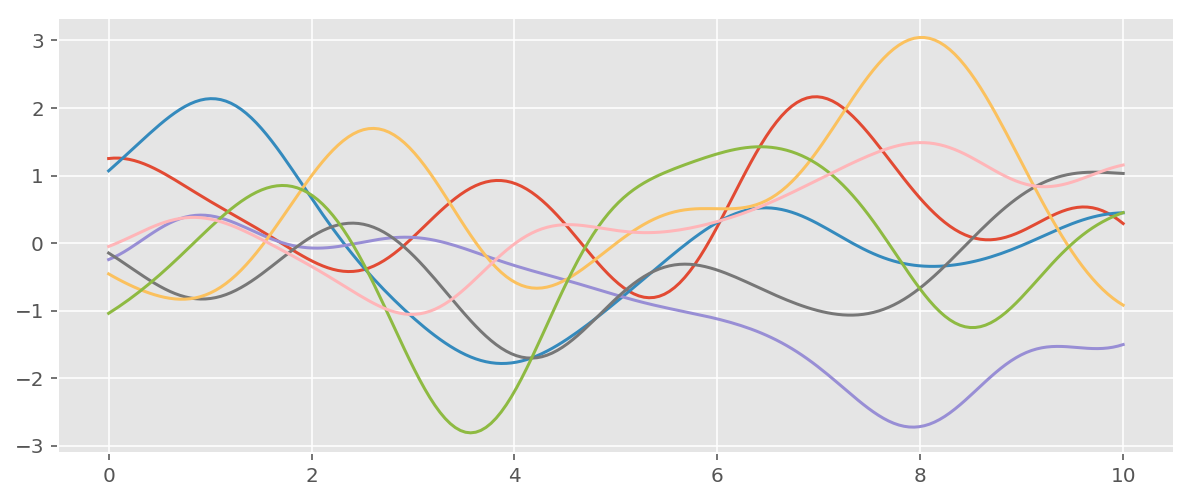

In [4]:
import theano
import theano.tensor as tt

np.random.seed(20170401)
n, n2 = 50, 200
Z = np.linspace(0, 10, n2)[:,None]

l_true, s2_f_true, s2_n_true = 1., 1., 0
with pm.Model() as model:
    # cov
    cov = pm.gp.cov.ExpQuad(1, l_true)
    # noise, epsilon
    K_noise = s2_n_true**2 * tt.eye(n2)
    
# evaluate the covariance with the given hyperparameters
K1 = theano.function([], cov(Z)+K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
ymu = np.random.multivariate_normal(np.zeros(n2), K1, 7)

ax1 = plt.figure(figsize=(10,4))
plt.plot(Z, ymu.T, ms=10);

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process. But actually, using a Gaussian Process is mathethmatically equvallent to use a set of small base function (condition applies of course). For example, it could be shown that squared exponential covariance function is equivalent to regression using infinitely many Gaussian shaped basis functions placed everywhere (not just at your training points).  

In fact, Gaussian Process was quite extensively studied in Machine Learning Community (it was called a Machine learning tool), and has quite a lot of connection with Deep learning and neural network. Quoting from Yarin Gal's [blog](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) that summarised this nicely: 
> Take a neural network (a recursive application of weighted linear functions followed by non-linear functions), put a probability distribution over each weight (a normal distribution for example), and with infinitely many weights you recover a Gaussian process (see [Neal](http://www.cs.toronto.edu/pub/radford/thesis.pdf) or [Williams](http://papers.nips.cc/paper/1197-computing-with-infinite-networks.pdf) for more details).

Most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

# Posterior prediction

It is not always easy to understand prediction in GP at the beginning, especially if you are used to think of $y=f(x, \lambda)$ and parameters $\lambda$ being estimated to return a tide bound function. With $\mathcal{N}(mu=0, \Sigma)$, it is not always immediately apparent how to generate posterior prediction from a zero mean Gaussian. In fact, prediction from Gaussian Process is conditioned on the input data:  

$$ f_*|X_*, X, f \sim \mathcal{N}(K(X_*, X)K(X, X)^{-1}f, K(X_*, X_*)-K(X_*, X)K(X, X)^{-1}K(X, X_*))$$

For example, given the below observation:

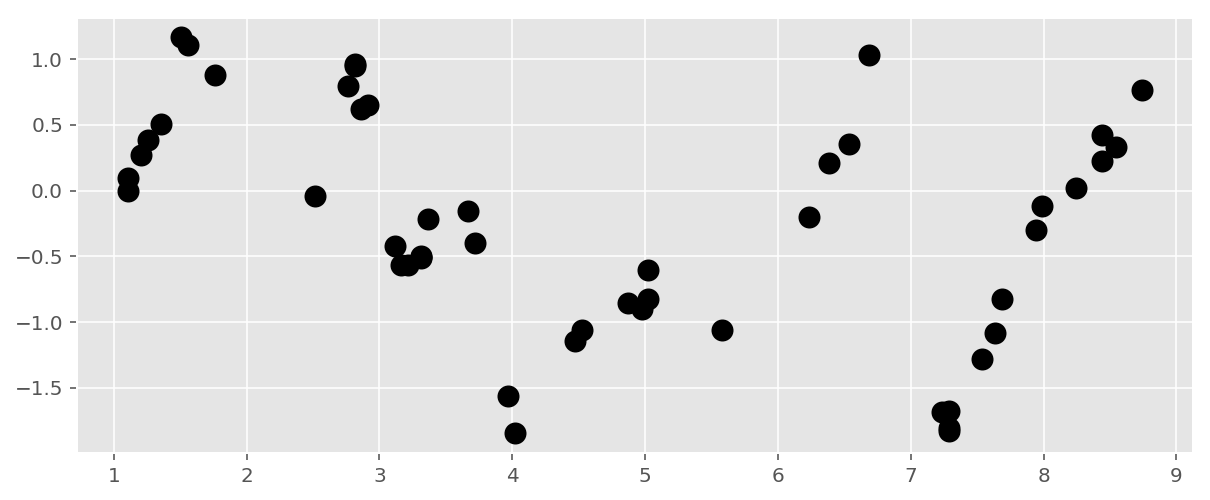

In [5]:
X = np.random.choice(Z[(Z>1)*(Z<9)], n)[:, None]

l_true, s2_f_true, s2_n_true = .3, 1., .1
with pm.Model() as model:
    # cov
    cov = pm.gp.cov.ExpQuad(1, l_true)
    # noise, epsilon
    K_noise = s2_n_true**2 * tt.eye(n)
    
# evaluate the covariance with the given hyperparameters
K1 = theano.function([], cov(X)+K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
ymu = np.random.multivariate_normal(np.zeros(n), K1)

ax1 = plt.figure(figsize=(10,4))
plt.plot(X, ymu, 'ok', ms=10);

We can make prediction on the points that are not been observed. In effect, this is generating from the conditional pdf.

In [6]:
from theano.tensor.slinalg import solve_lower_triangular as solve_lt
from theano.tensor.slinalg import solve_upper_triangular as solve_ut
from theano.tensor.slinalg import cholesky
from theano.tensor.nlinalg import matrix_inverse
S_xz = cov(X,Z)
S_zz = cov(Z)
K = cov(X) + K_noise
L = tt.slinalg.cholesky(K)
alpha = solve_ut(L.T, solve_lt(L, ymu))
S_xz = cov(X,Z)
m_post = theano.function([], tt.dot(S_xz.T, alpha))()
v = solve_lt(L, S_xz)
S_post = theano.function([], S_zz - tt.dot(v.T, v))()
# S_chol = theano.function([], cholesky(S_zz - tt.dot(v.T, v)))()

# Using Matrix inverse, slower
# S_inv = matrix_inverse(cov(X) + K_noise)
# m_post = theano.function([], tt.dot(tt.dot(S_xz.T, S_inv), ymu))()
# S_post = theano.function([], S_zz - tt.dot(tt.dot(S_xz.T, S_inv), S_xz))()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


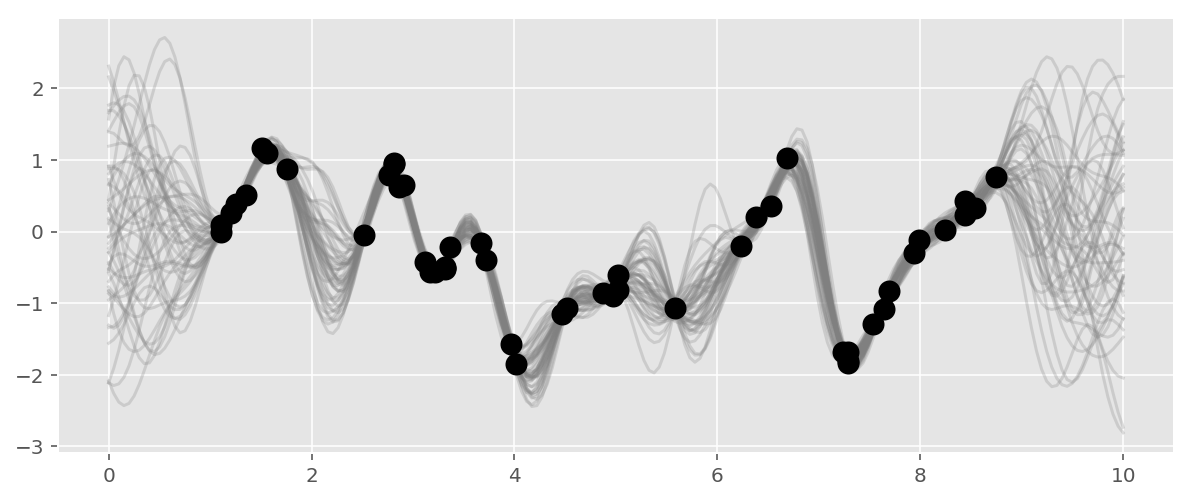

In [7]:
# generate fake data from GP with white noise (with variance sigma2)
ystim = np.random.multivariate_normal(m_post, S_post, 50)

ax1 = plt.figure(figsize=(10,4))
plt.plot(Z, ystim.T, c='gray',alpha=.25, ms=10)
plt.plot(X, ymu, 'ok', ms=10);

# Parameter estimation (Gaussian Likelihood)

In [8]:
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=3) 
    
    # prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2)
    
    # prior on the noise variance
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)

    intercept = pm.Cauchy('b',alpha=0,beta=10)
    meanfuc = pm.gp.mean.Constant(intercept)
    
    Sigma = f_cov(X) + tt.eye(n)*s2_n**2
    
    # y_obs = pm.MvNormal('y_obs', mu=meanfuc(X).squeeze(), cov=Sigma, observed=ymu)
    y_obs = pm.gp.GP('y_obs', 
                     mean_func=meanfuc, 
                     cov_func=f_cov, 
                     sigma=s2_n,
                     X=X,
                     observed=ymu,
                     total_size=n)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,216.6:  17%|█▋        | 34714/200000 [00:30<02:15, 1215.83it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -406.44

100%|██████████| 2000/2000 [00:21<00:00, 92.62it/s] 


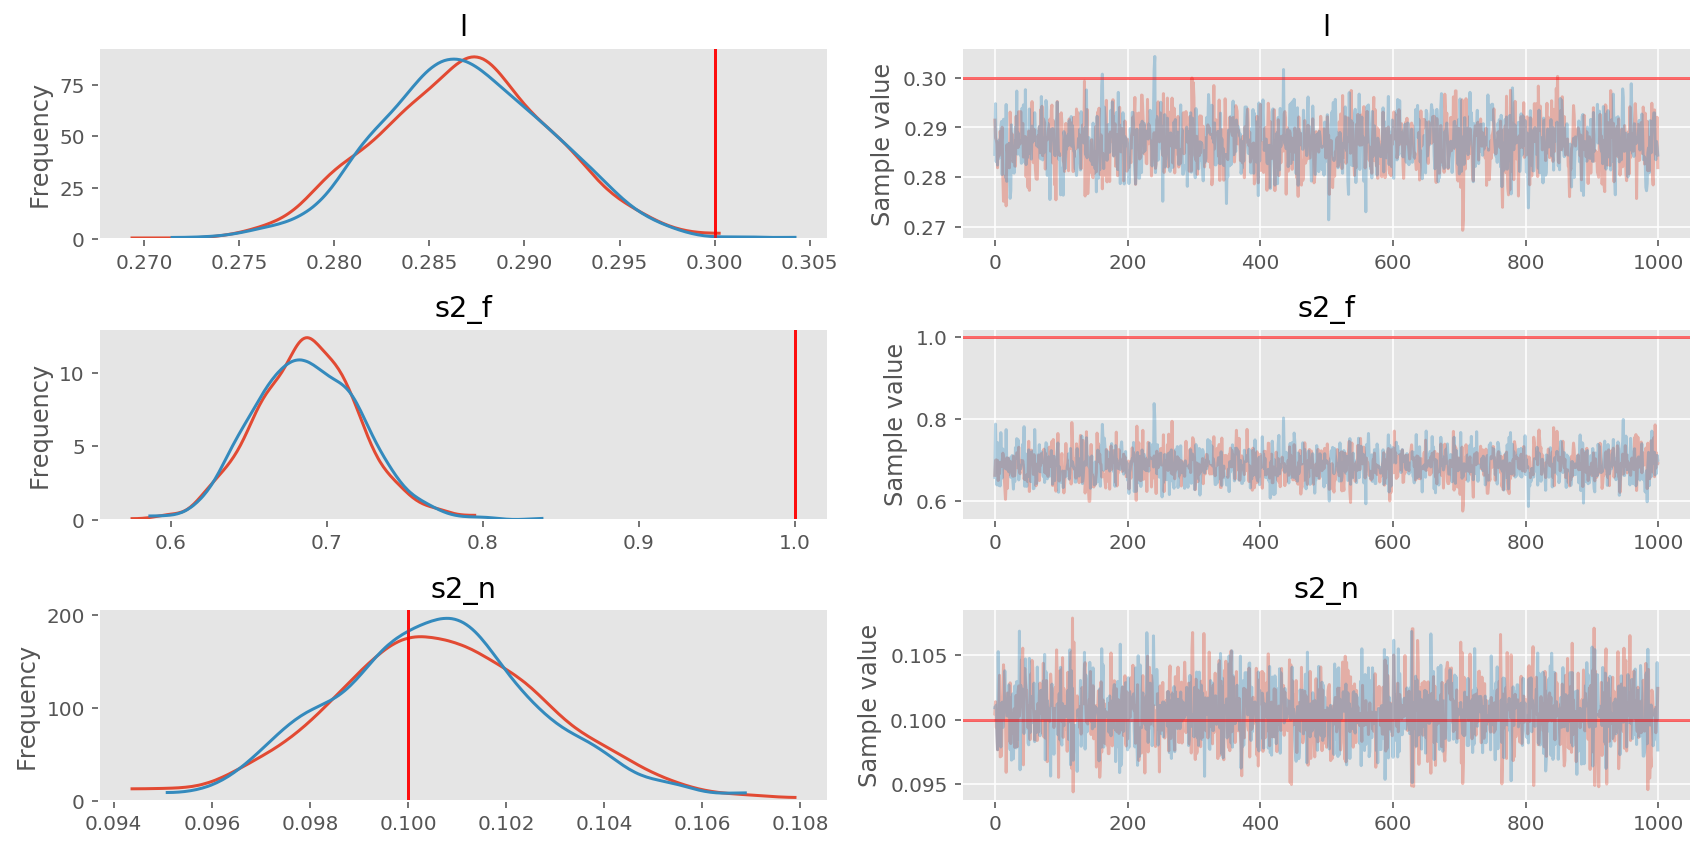

In [9]:
with model:
    trace = pm.sample(2000, njobs=2, tune=1000)
temp_trace = trace[1000:]

pm.traceplot(temp_trace, varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

The PyMC3 MvNormal distribution is recently under some changes, using the older implementation below.

In [10]:
from pymc3.distributions.distribution import Continuous,draw_values,generate_samples
from scipy import stats
def get_tau_cov(mu, tau=None, cov=None):
    """
    Find precision and standard deviation
    .. math::
        \Tau = \Sigma^-1
    Parameters
    ----------
    mu : array-like
    tau : array-like, not required if cov is passed
    cov : array-like, not required if tau is passed
    Results
    -------
    Returns tuple (tau, sd)
    Notes
    -----
    If neither tau nor cov is provided, returns an identity matrix.
    """
    if tau is None:
        if cov is None:
            raise ValueError('Incompatible parameterization. Either use tau'
                             'or cov to specify distribution.')
        else:
            tau = tt.nlinalg.matrix_inverse(cov)

    else:
        if cov is not None:
            raise ValueError("Can't pass both tau and sd")
        else:
            cov = tt.nlinalg.matrix_inverse(tau)

    return (tau, cov)

class MvNormal(Continuous):
    R"""
    Multivariate normal log-likelihood.
    .. math::
       f(x \mid \pi, T) =
           \frac{|T|^{1/2}}{(2\pi)^{1/2}}
           \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime} T (x-\mu) \right\}
    ========  ==========================
    Support   :math:`x \in \mathbb{R}^k`
    Mean      :math:`\mu`
    Variance  :math:`T^{-1}`
    ========  ==========================
    Parameters
    ----------
    mu : array
        Vector of means.
    cov : array
        Covariance matrix. Not required if tau is passed.
    tau : array
        Precision matrix. Not required if tau is passed.
    Flags
    ----------
    gpu_compat : False, because LogDet is not GPU compatible yet.
                 If this is set as true, the GPU compatible (but numerically unstable) log(det) is used.
    """

    def __init__(self, mu, cov=None, tau=None, gpu_compat=False, *args, **kwargs):
        super(MvNormal, self).__init__(*args, **kwargs)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(mu)
        tau, cov = get_tau_cov(mu, tau=tau, cov=cov)
        self.tau = tt.as_tensor_variable(tau)
        self.cov = tt.as_tensor_variable(cov)
        self.gpu_compat = gpu_compat
        if gpu_compat is False and theano.config.device == 'gpu':
            warnings.warn("The function used is not GPU compatible. Please check the gpu_compat flag")

    def random(self, point=None, size=None):
        mu, cov = draw_values([self.mu, self.cov], point=point)

        def _random(mean, cov, size=None):
            return stats.multivariate_normal.rvs(
                mean, cov, None if size == mean.shape else size)

        samples = generate_samples(_random,
                                   mean=mu, cov=cov,
                                   dist_shape=self.shape,
                                   broadcast_shape=mu.shape,
                                   size=size)
        return samples

    def logp(self, value):
        mu = self.mu
        tau = self.tau

        delta = value - mu
        k = tau.shape[0]

        result = k * tt.log(2 * np.pi)
        if self.gpu_compat:
            result -= tt.log(det(tau))
        else:
            result -= logdet(tau)
        result += (tt.dot(delta, tau) * delta).sum(axis=delta.ndim - 1)
        return -1 / 2. * result

from pymc3.model import modelcontext
from theano.tensor.nlinalg import matrix_inverse
def sample_gp(trace, K, sigma, X_values, samples=None, obs_noise=True, model=None, 
              random_seed=None, progressbar=True):
    """Generate samples from a posterior Gaussian process.
    Parameters
    ----------
    trace : backend, list, or MultiTrace
        Trace generated from MCMC sampling.
    gp : Gaussian process object
        The GP variable to sample from.
    X_values : array
        Grid of values at which to sample GP.
    samples : int
        Number of posterior predictive samples to generate. Defaults to the
        length of `trace`
    obs_noise : bool
        Flag for including observation noise in sample. Defaults to True.
    model : Model 
        Model used to generate `trace`. Optional if in `with` context manager.
    random_seed : integer > 0
        Random number seed for sampling.
    progressbar : bool
        Flag for showing progress bar.
    
    Returns
    -------
    Array of samples from posterior GP evaluated at Z.
    """
    model = modelcontext(model)
    
    if samples is None:
        samples = len(trace)
    
    if random_seed:
        np.random.seed(random_seed)
    
    if progressbar:
        indices = tqdm(np.random.randint(0, len(trace), samples), total=samples)
    else:
        indices = np.random.randint(0, len(trace), samples)

    X = X_values['X']
    Y = X_values['Y']
    Z = X_values['Z']
    
    S_xz = K(X, Z)
    S_zz = K(Z)
    if obs_noise:
        S_inv = matrix_inverse(K(X) + tt.eye(X.shape[0])*sigma**2)
    else:
        S_inv = matrix_inverse(K(X))

    # Posterior mean
    m_post = tt.dot(tt.dot(S_xz.T, S_inv), Y)
    # Posterior covariance
    S_post = S_zz - tt.dot(tt.dot(S_xz.T, S_inv), S_xz)
    gp_post = MvNormal.dist(m_post, cov=S_post, shape=Z.shape[0])
    
    # S_post_chol = qr_chol(S_post)
    # gp_post = pm.MvNormal.dist(m_post, chol=S_post_chol, shape=Z.shape[0])
    
    samples = [gp_post.random(point=trace[idx]) for idx in indices]
    
    return np.array(samples)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


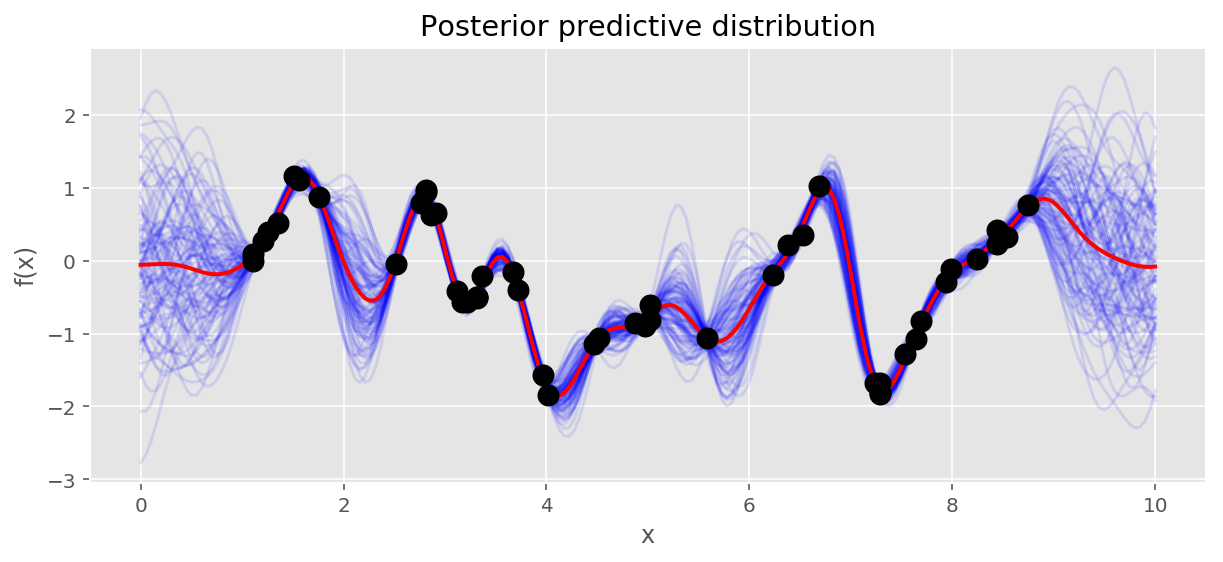

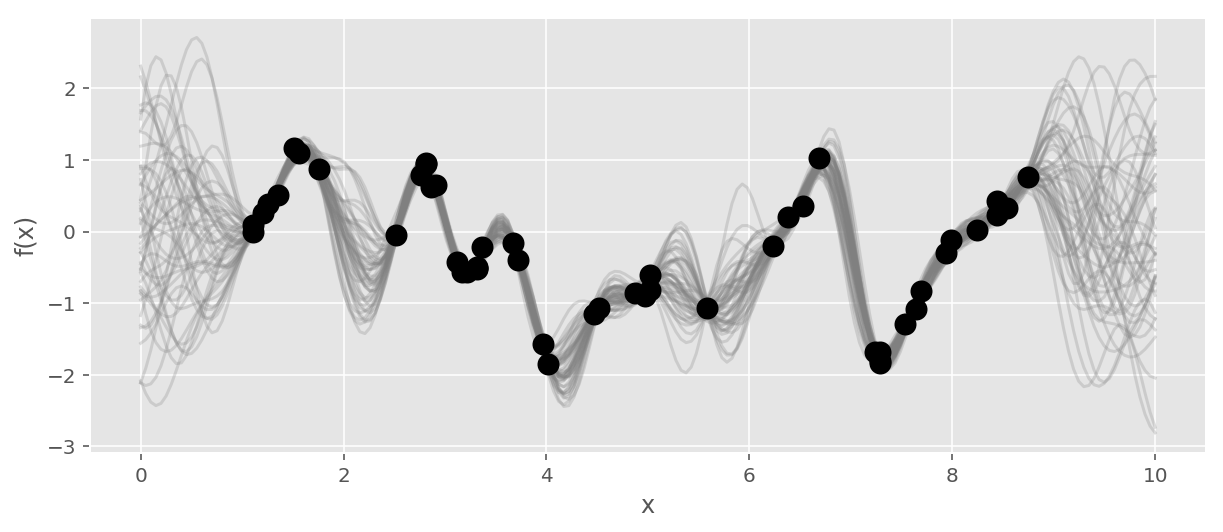

In [11]:
nsample = 100
X_values = {'X':X, 'Y':ymu, 'Z':Z}
with model:
    gp_samples = sample_gp(temp_trace, f_cov, s2_n, X_values, obs_noise=True, 
                           samples=nsample, progressbar=None)
#     gp_samples = pm.gp.sample_gp(temp_trace, y_obs, Z, 
#                                  samples=nsample, progressbar=None)

_, ax = plt.subplots(figsize=(10,4))

[ax.plot(Z, x, color='b', alpha=0.1) for x in gp_samples]
meanline = np.mean(gp_samples, 0)
line, = ax.plot(Z.squeeze(), meanline,color='r', lw=2)

# overlay the observed data
ax.plot(X, ymu, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

_, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(Z, ystim.T, c='gray',alpha=.25, ms=10)
ax1.plot(X, ymu, 'ok', ms=10)
ax1.set_xlabel("x");
ax1.set_ylabel("f(x)");

# Parameter estimation (Non-Gaussian Likelihood)

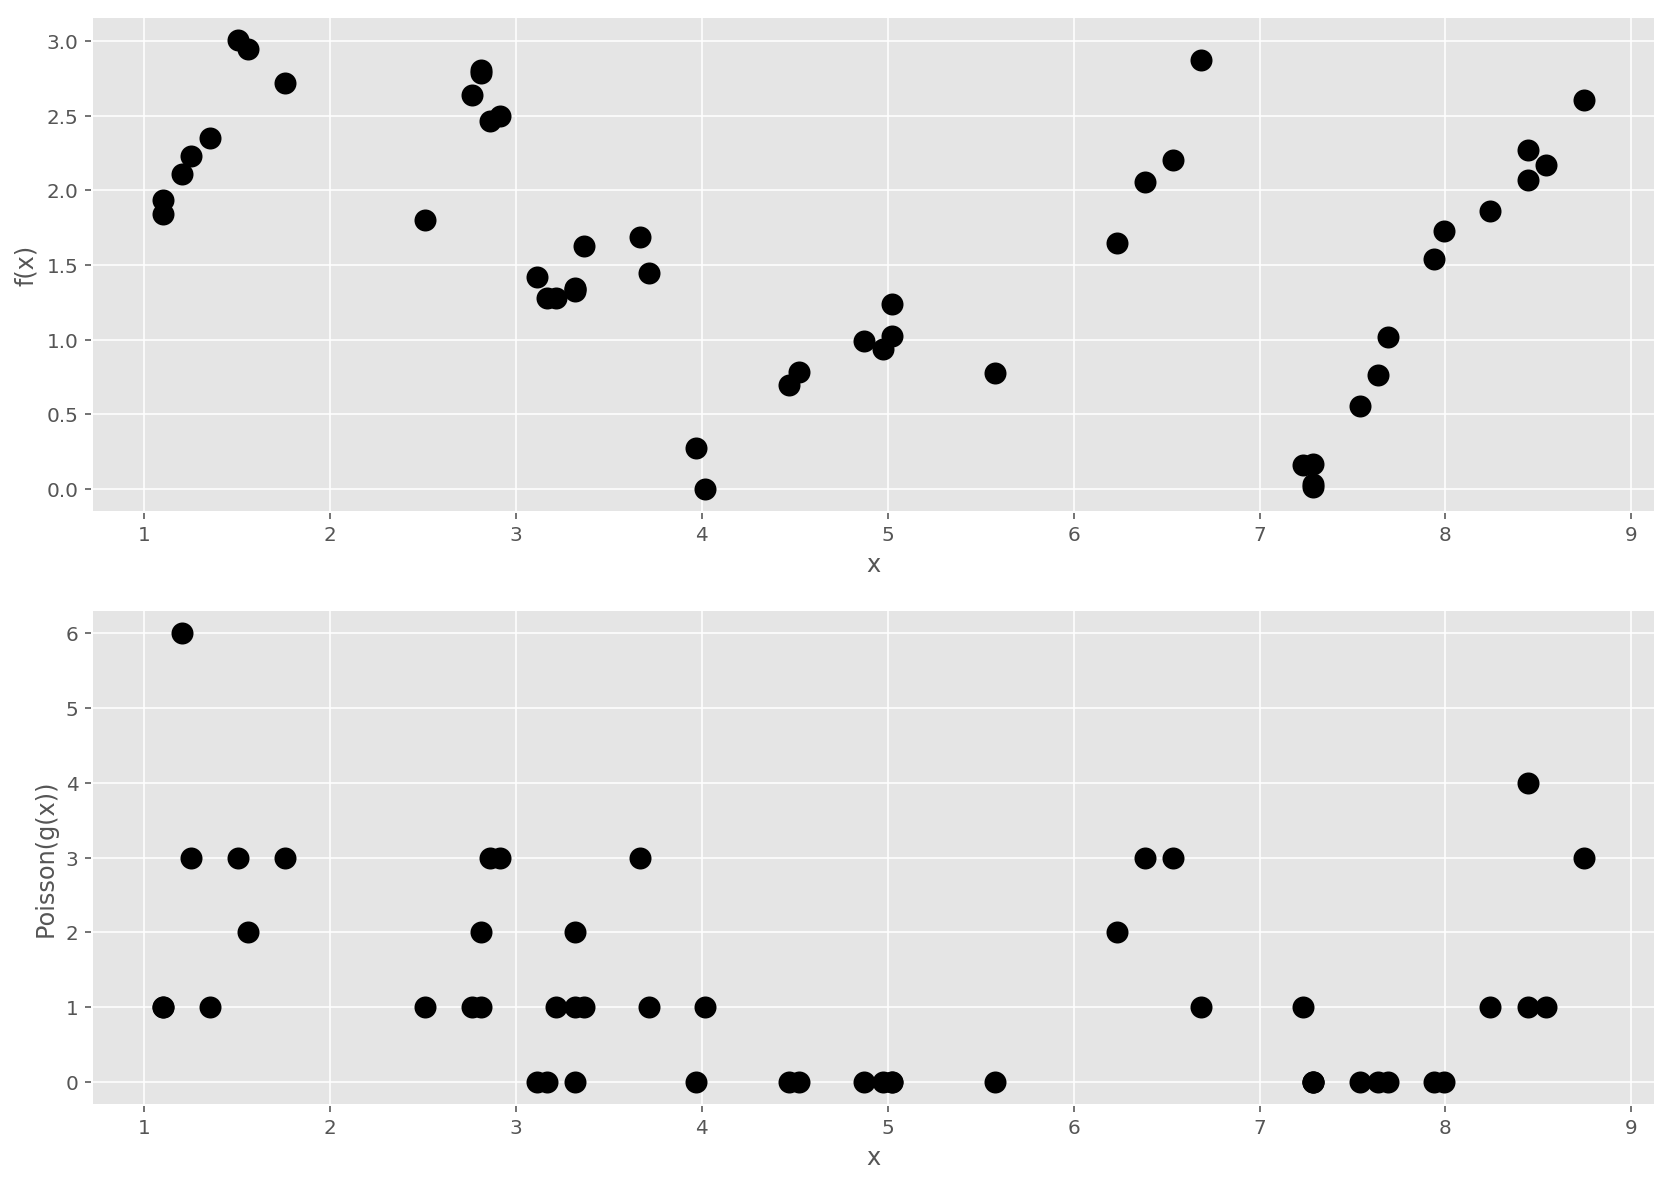

In [12]:
ymu1 = (ymu - ymu.min())
y = np.random.poisson(np.exp(ymu))

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(211)
ax1.plot(X, ymu1, 'ok', ms=10)
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")

ax1 = fig.add_subplot(212)
ax1.plot(X, y, 'ok', ms=10)
ax1.set_xlabel("x")
ax1.set_ylabel("Poisson(g(x))")

plt.show()

In [13]:
jitter = 1e-6
with pm.Model() as model_ng:
    # priors on the covariance function hyperparameters
    l = pm.Gamma('l', alpha=1, beta=1) 
    
    # prior on the function variance
    s2_f = pm.Gamma('s2_f', alpha=1, beta=1) 
    
    # prior on the noise variance
    s2_n = pm.Gamma('s2_n', alpha=1, beta=1) 
    
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)
    
    Sigma = f_cov(X) + tt.eye(n) * s2_n**2
    
#     # add fixed amount of jitter to guarantee numerically stable
#     L = tt.slinalg.cholesky(Sigma + jitter * tt.eye(n)) 
#     v = pm.Normal("v", mu=0.0, sd=1.0, shape=(n,1))  
#     y_mu = pm.Deterministic("f", tt.dot(L, v))
    
    y_mu = pm.MvNormal('y_mu', mu=0., cov=Sigma, shape=(n,))
    
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(y_mu), observed=y)

In [14]:
with model_ng:
    # New ADVI api
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace = approx.sample_vp(2000) 
    
    elbos1 = -inference.hist

Average Loss = 76.654: 100%|██████████| 20000/20000 [00:34<00:00, 583.83it/s]
Finished [100%]: Average Loss = 76.663
Average Loss = 75.298: 100%|██████████| 10000/10000 [00:18<00:00, 528.80it/s]
Finished [100%]: Average Loss = 75.301


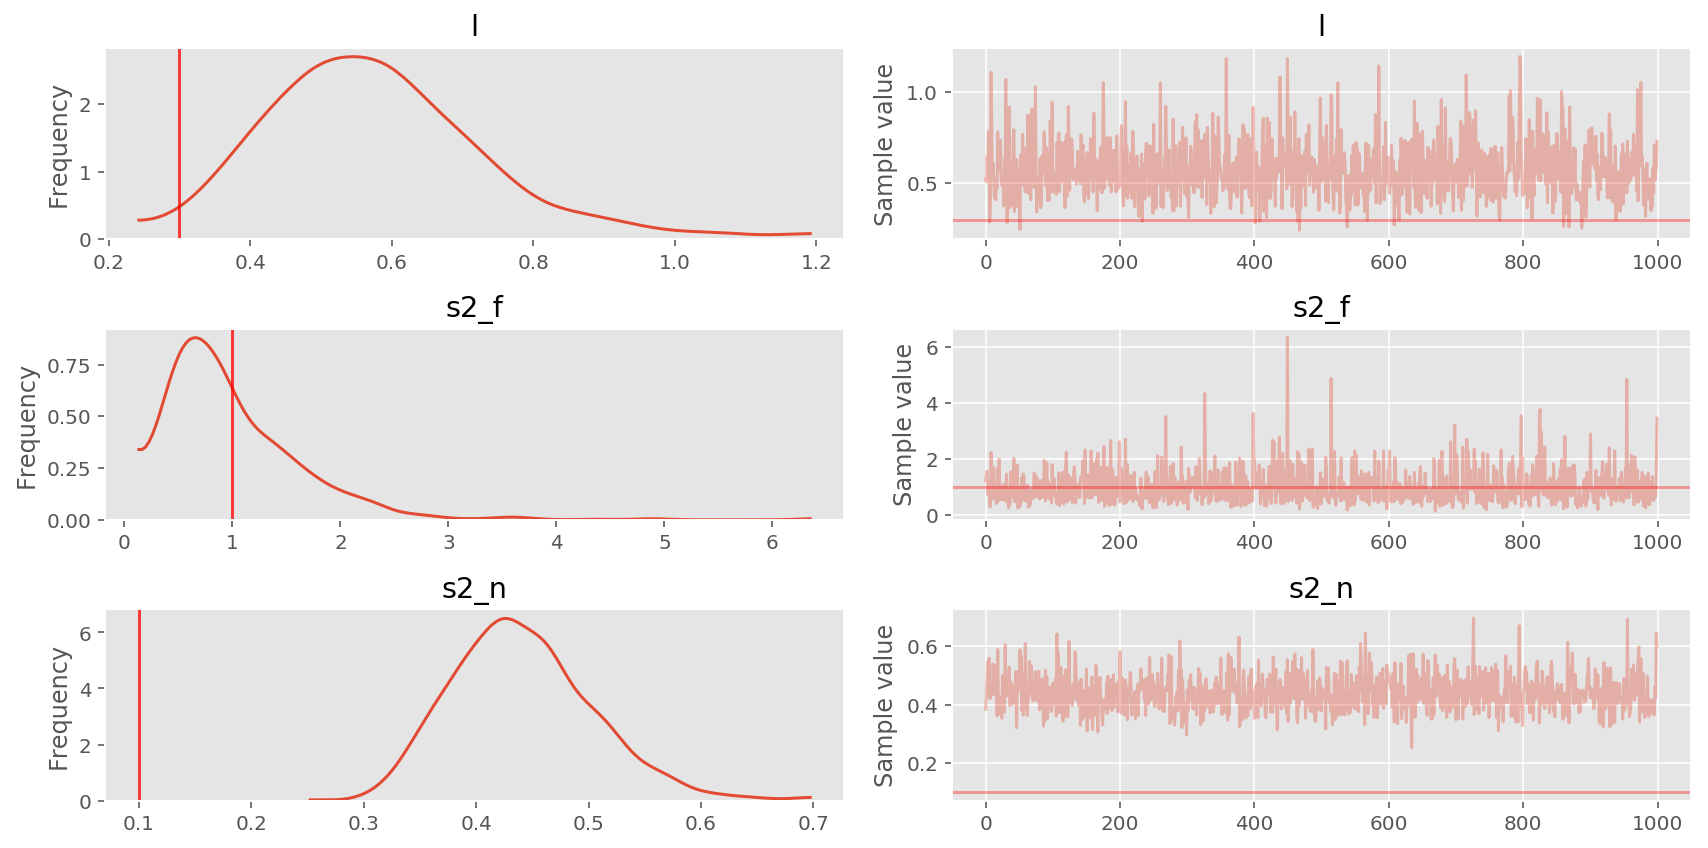

In [15]:
temp_trace = trace[1000:]

pm.traceplot(temp_trace, varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -79.048: 100%|██████████| 200000/200000 [03:04<00:00, 1083.64it/s]
Finished [100%]: Average ELBO = -78.996
 36%|███▌      | 719/2000 [02:41<01:03, 20.28it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:265: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.61380169082, but should be close to 0.8. Try to increase the number of tuning steps.
  % (chain, mean_accept, target_accept))
100%|█████████▉| 1997/2000 [03:49<00:00, 32.08it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:265: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.615491263664, but should be close to 0.8. Try to increase the number of tuning steps.
  % (chain, mean_accept, target_accept))
100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s]


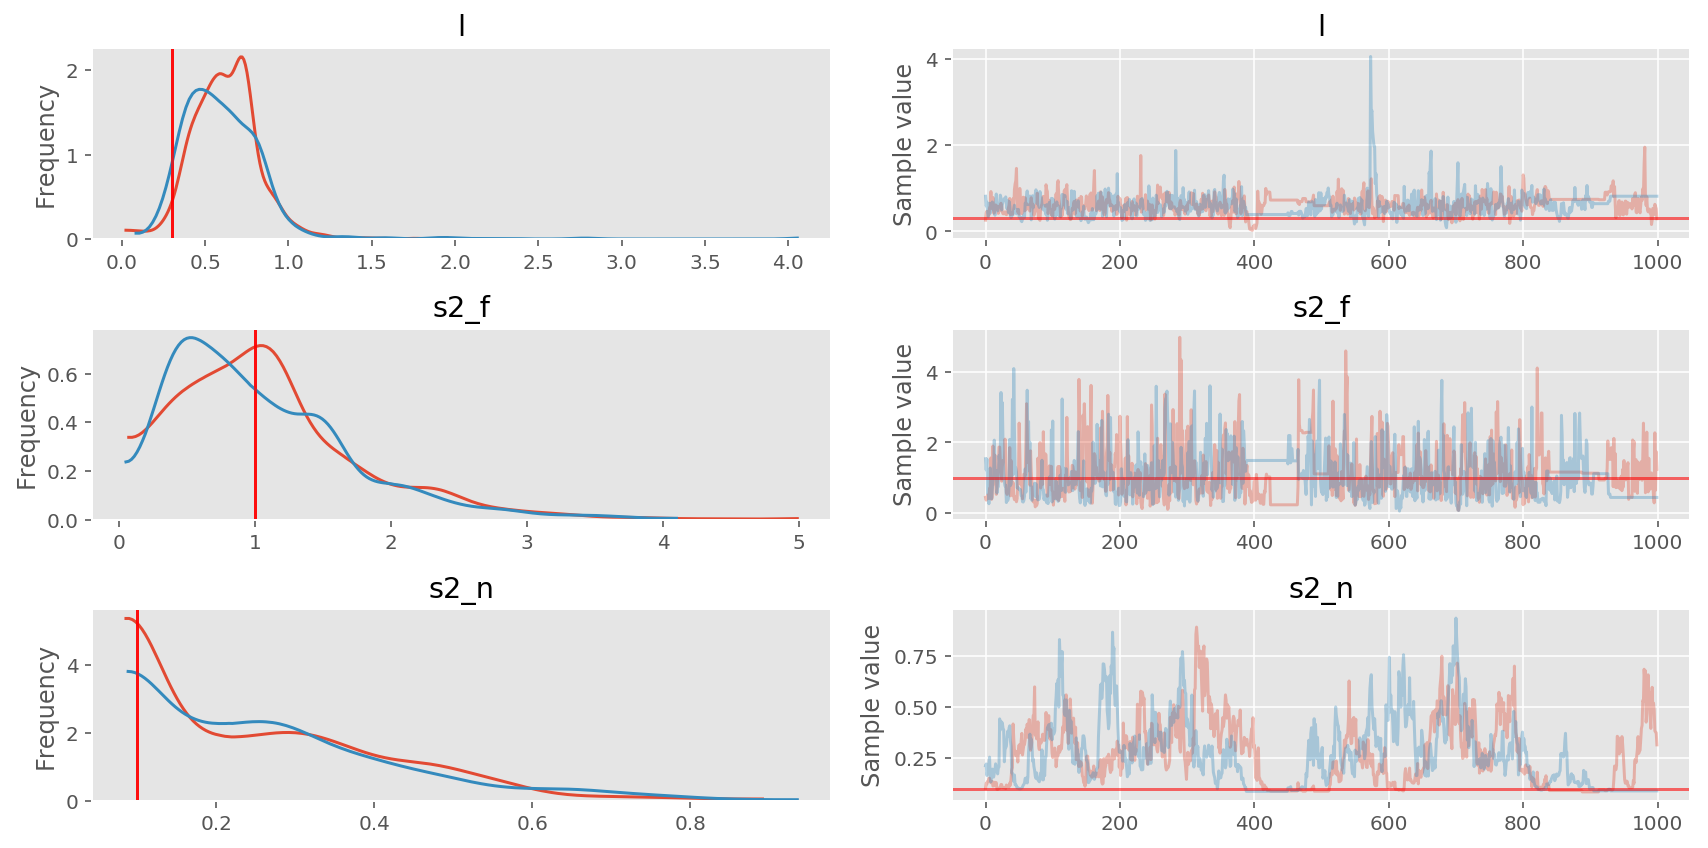

In [16]:
with model_ng:
    trace = pm.sample(2000, njobs=2, tune=1000)

temp_trace = trace[1000:]

pm.traceplot(temp_trace, varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


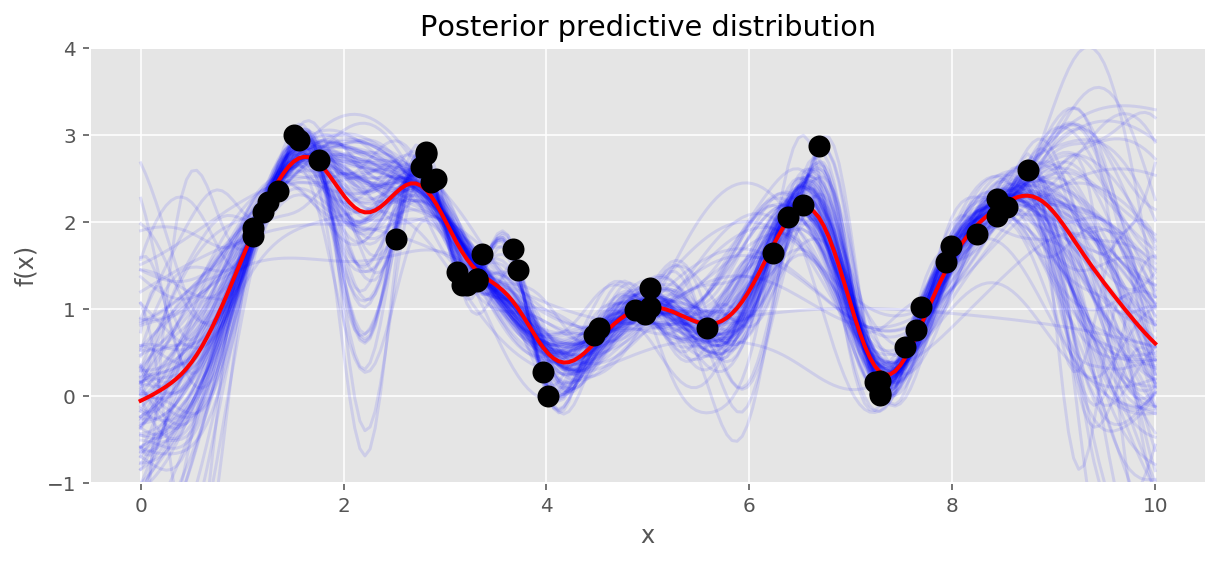

In [17]:
nsample = 100
X_values = {'X':X, 'Y':ymu1, 'Z':Z}
with model:
    gp_samples = sample_gp(temp_trace, f_cov, s2_n, X_values, obs_noise=True, model=model_ng,
                           samples=nsample, progressbar=None)
#     gp_samples = pm.gp.sample_gp(temp_trace, y_obs, Z, 
#                                  samples=nsample, progressbar=None)

_, ax = plt.subplots(figsize=(10,4))

[ax.plot(Z, x, color='b', alpha=0.1) for x in gp_samples]
meanline = np.mean(gp_samples, 0)
line, = ax.plot(Z.squeeze(), meanline,color='r', lw=2)

# overlay the observed data
ax.plot(X, ymu1, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
plt.ylim(ymu1.min()-1, ymu1.max()+1)
ax.set_title("Posterior predictive distribution");

In [18]:
import GPflow
X2 = X
Y2 = np.asarray(y[:,None],dtype=np.double)

#build the model
# k = GPflow.kernels.RBF(1,ARD=False)
u = GPflow.mean_functions.Constant()
k = GPflow.kernels.RBF(1,ARD=False) + GPflow.kernels.Bias(1)
l = GPflow.likelihoods.Poisson()
m = GPflow.gpmc.GPMC(X2, Y2, k, l, mean_function=u)

m.kern.rbf.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.rbf.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.bias.variance.prior = GPflow.priors.Gamma(1.,1.)

# m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
# m.kern.variance.prior = GPflow.priors.Gamma(1.,1.)

m.optimize(maxiter=15) # start near MAP
samples = m.sample(2000, verbose=True, epsilon=0.0075, Lmax=15)

Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  99.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  100.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  100.0 %
Iteration:  1600 	 Acc Rate:  100.0 %
Iteration:  1700 	 Acc Rate:  100.0 %
Iteration:  1800 	 Acc Rate:  100.0 %
Iteration:  1900 	 Acc Rate:  100.0 %
Iteration:  2000 	 Acc Rate:  100.0 %


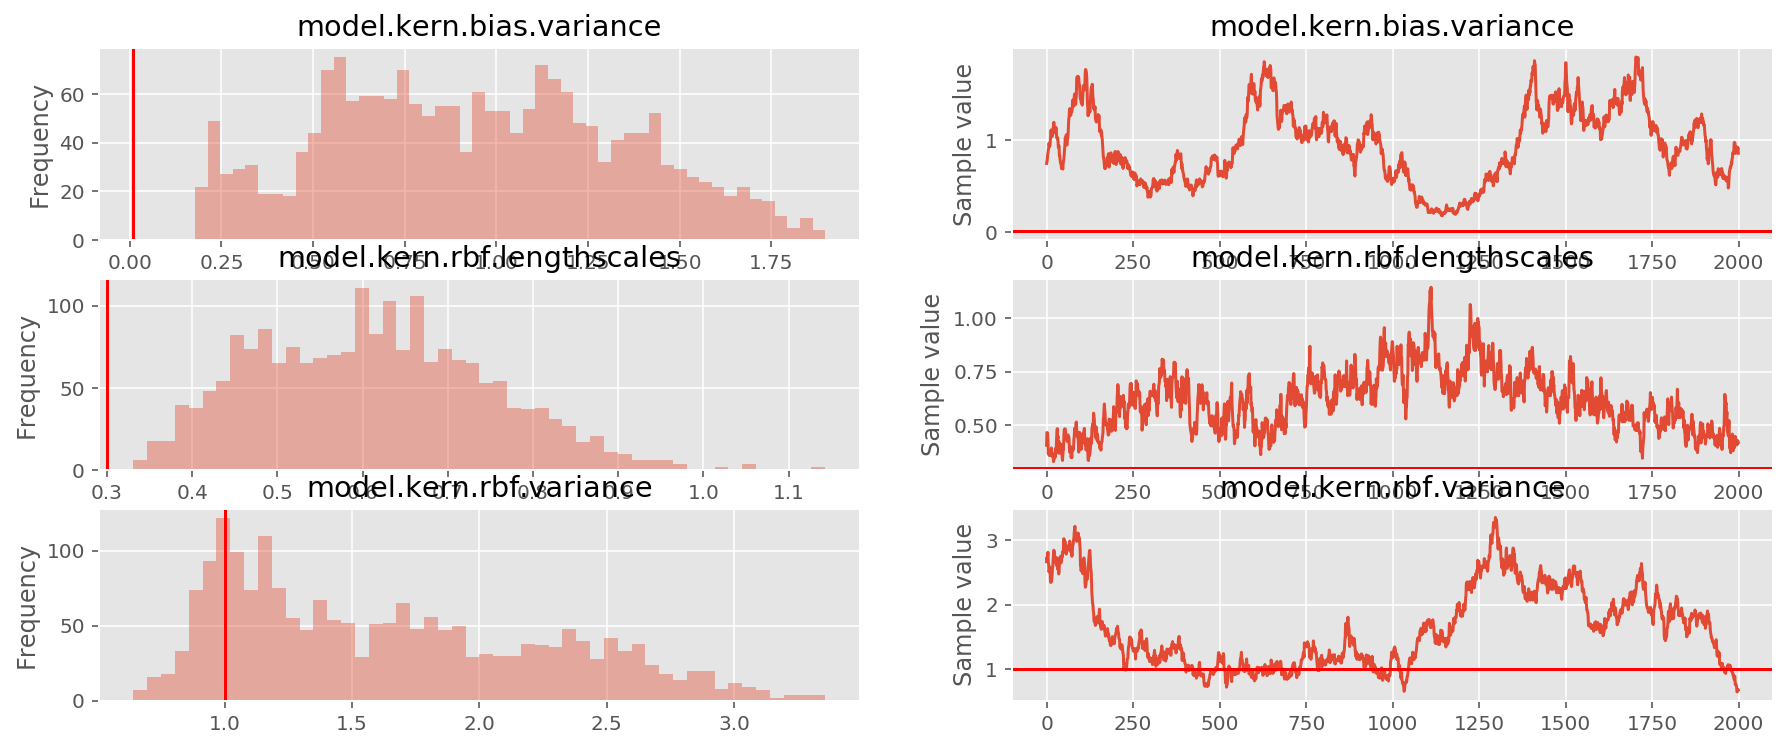

In [19]:
f, ax = plt.subplots(3, 2, figsize=(15,6))
parameter_samples = m.get_samples_df(samples)
reallineval = [s2_n_true**2,l_true,s2_f_true,]
for ii, col in enumerate(parameter_samples.columns.sort_values()[1:-1]):
    temp = np.asarray(parameter_samples[col])
    ax[ii,0].hist(temp,alpha=0.4, bins=50)
    ax[ii,0].set_title(str(col))
    ax[ii,1].plot(temp)
    ax[ii,1].set_title(str(col))
    ax[ii, 0].set_ylabel("Frequency")
    ax[ii, 1].set_ylabel("Sample value")
    ax[ii, 0].axvline(reallineval[ii],color='r')
    ax[ii, 1].axhline(reallineval[ii],color='r')
plt.show()

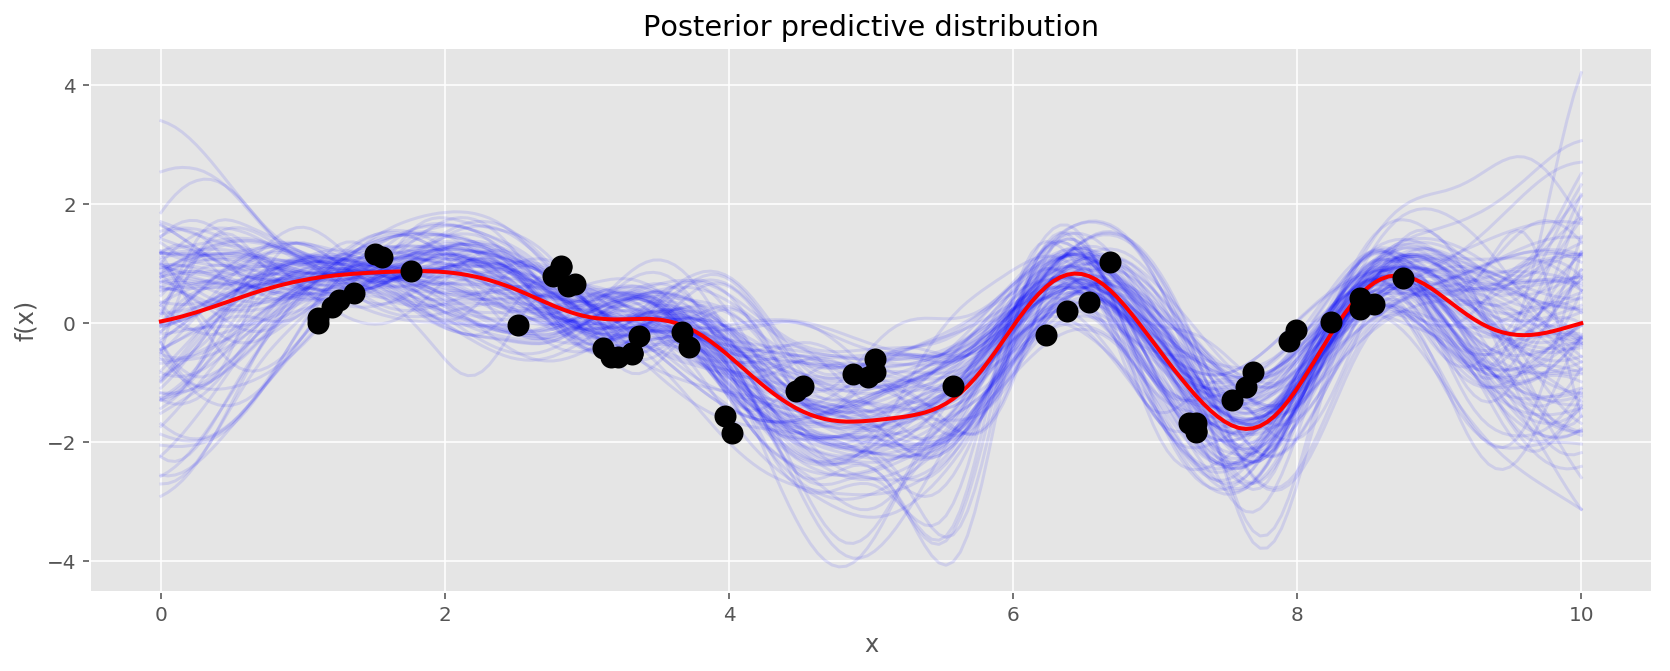

In [20]:
realizations = []
samples2 = samples
nsample = 100
indices = np.random.randint(0, len(samples2), nsample)
for sample in samples2[indices]:
    m.set_state(sample)
    realizations.append(m.predict_f_samples(Z, 1).squeeze())
realizations = np.vstack(realizations)

fig, ax = plt.subplots(figsize=(14, 5))

[ax.plot(Z.squeeze(), draw, color='b', alpha = 0.1) for draw in realizations]
    
meanline = np.mean(realizations, 0)
line, = ax.plot(Z.squeeze(), meanline,color='r', lw=2)
# overlay the observed data
ax.plot(X, ymu, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");
plt.show()

# References and other useful resource


### Theory  

* Rasmussen, C. E. and Williams, C. K. I. (2006). [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).
MIT Press. 238, 245  
  

### Intuition  

* [Gaussian Process Models in Python](http://nbviewer.jupyter.org/github/fonnesbeck/gp_showdown/blob/master/GP%20Showdown.ipynb) by Chris Fonnesbeck  
* [Video Lecture](http://videolectures.net/mlss07_rasmussen_bigp/) by Carl Rasmussen  
* Link between Deep neural network and Gaussian Process, [Blog post](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) by  Yarin Gal

  
### Practical  

* [GPML](http://www.gaussianprocess.org/gpml/code/matlab/doc/)  
* Using [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html)  
* GP in Stan see [Manual Chapter 17](https://github.com/stan-dev/stan/releases/download/v2.14.0/stan-reference-2.14.0.pdf) and [Stan example](https://github.com/stan-dev/example-models/tree/master/misc/gaussian-process). Also some information on [Prior choice](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#priors-for-gaussian-processes)   
* [GPy](https://github.com/sheffieldml/gpy) from Sheffield machine learning group  
* [GPflow](https://github.com/GPflow/GPflow)  
* [PyMC3 GP module](http://pymc-devs.github.io/pymc3/examples.html#gaussian-processes)  